In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from magenta.models.nsynth import utils
from magenta.models.nsynth.wavenet import fastgen
from IPython.display import Audio
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'

/anaconda/envs/sample_embeddings/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


In [66]:
from os import walk

files = []
def isvalid(filename):
    return isfile(filename) and '.wav' in filename

for (dirpath, dirnames, filenames) in walk('samples'):
    filenames = [join(dirpath, f) for f in filenames if isvalid(join(dirpath, f))]
    files.extend(filenames)

In [69]:
sr = 16000
audio_data = []
for fname in files:
    audio = utils.load_audio(fname, sample_length=40000, sr=sr)
    sample_length = audio.shape[0]
    audio_data.append(audio)
    
audio_data = np.array(audio_data)
print(audio_data.shape)

(161, 32000)


In [70]:
checkpoint = 'checkpoints/wavenet-ckpt/model.ckpt-200000'
%time encoding = fastgen.encode(audio_files, checkpoint, sample_length)

INFO:tensorflow:Restoring parameters from checkpoints/wavenet-ckpt/model.ckpt-200000
CPU times: user 59min 26s, sys: 7min 1s, total: 1h 6min 28s
Wall time: 19min 43s


In [82]:
print(encoding.shape)

(161, 62, 16)
(161, 32000)


In [72]:
np.save('embeddings.npy', encoding)

samples/leads/Ice Synth Lead.wav


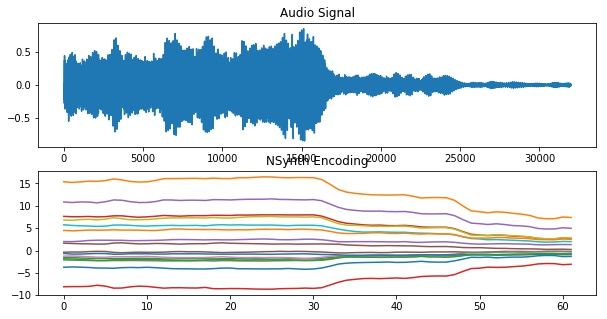

In [88]:
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
axs[0].plot(audio_files[11]);
axs[0].set_title('Audio Signal')
axs[1].plot(encoding[11]);
axs[1].set_title('NSynth Encoding')
print (files[11])

In [165]:
from sklearn.decomposition import PCA
nsamples, nx, ny = encoding.shape
reshaped = encoding.reshape((nsamples,nx*ny))
pca = PCA(3)
projected = pca.fit_transform(reshaped)

In [166]:
color_map = {
    "/bass": 1,
    "/keys": 2,
    "/leads": 3,
    "/mallets": 4,
    "/pads": 5,
    "/synth": 6,
    "/vocals": 7,
}
def get_color(filename):
    for (_, key) in enumerate(color_map):
        if key in filename:
            return color_map[key]

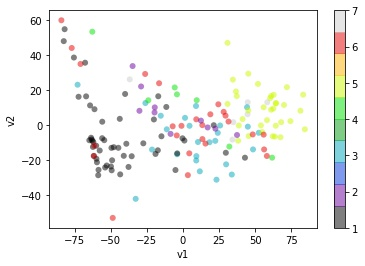

In [167]:
colors = [get_color(filename) for filename in files]
colors = np.array(colors)

plt.scatter(projected[:, 0], projected[:, 1], c=colors, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('spectral', 10))
plt.xlabel('v1')
plt.ylabel('v2')
plt.colorbar();

In [168]:
import json

entries = []
for i in range(len(projected)):
    proj = projected[i]
    filename = files[i]
    entry = {
        "index": i,
        "group": int(colors[i]),
        "proj": [float(i) for i in proj],
        "filename": filename,
    }
    entries.append(entry)
output = {}
output['data'] = entries

print(entries[0])

with open('3d_embeddings.json', 'w') as outfile:
    json.dump(output, outfile)

{'index': 0, 'group': 7, 'proj': [34.87606430053711, 1.48587965965271, -12.604253768920898], 'filename': 'samples/vocals/Vowel Pad.wav'}
